In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfb = tfp.bijectors
from gp_models import CustomKernel,GP_model, GPR_model, GPR_analytical
from pricing_models import Black_Scholes, LVM
from data import training_data, test_data

In [2]:
#Define pricing model and training data grid 

#Illustration section 2.5
bs_model = Black_Scholes()
X,y,df = training_data(bs_model,S_min = 32,S_max = 68,N_points=100,halton=True,virtual=False,mc=True,nsim=5000)

#KrigHedge demo from appendix
# df_demo = pd.read_csv('demoData.csv')
# df_demo.rename({'price': 'mc_price','price_anal':'price'},axis=1,inplace = True)
# X1 = np.array(df_demo.iloc[:400,:2])
# X2 = np.array(df_demo.iloc[400:,:2])
# y1 = np.array(df_demo.mc_price[:400])
# y2 = np.array(df_demo.mc_price[400:])
# X = np.concatenate((X1,X2))
# y = np.concatenate((y1,y2))


In [3]:
#Define trainable variables

#Mean function variables
b0 = tf.Variable(0,dtype=tf.float64, name = 'b0')
b = tf.Variable([[1,1]],dtype=tf.float64, name= 'b12')
b1 = tf.Variable([1],dtype=tf.float64, name= 'b1')
b2 = tf.Variable([0],dtype=tf.float64, name= 'b2')
#Kernel variables
process_variance = 100
noise_variance = 0.0001
length_scales =[1,20]
sp = tfp.util.TransformedVariable(process_variance, tfb.Exp(), dtype=tf.float64, name='sigma_process')
sn2 = tfp.util.TransformedVariable(noise_variance, tfb.Exp(), dtype=tf.float64, name='sigma_noise2')
scales = tf.Variable(length_scales,constraint = lambda x: tf.clip_by_value(x,[0.1,10],[2,50]),dtype=tf.float64, name = 'length_scales')

#Define custom kernel
kernel_family = 'M52'
param ={'amp' : sp , 'scales': scales,'family' : kernel_family}
my_kernel = CustomKernel(1,parameters = param)
#Define mean function
def mean_f(x): return tf.squeeze(b0 + tf.linalg.matmul(x, b, transpose_b=True))
def mean_f(x): return b0 + b2*x[:,-1] # + b1*x[:,0]

In [4]:
#Define test data
test_stocks = np.linspace(30,70,29)
tau = 0.2
X_test, y_test = test_data(bs_model,tau,test_stocks)
delta_test = bs_model.delta(test_stocks,tau)
theta_test = bs_model.theta(test_stocks,tau)
#test_stocks

In [5]:
#Define and fit the model
GP = GP_model(my_kernel, index_points=X,mean_fn=mean_f, beta=(b0,b2),observation_noise_variance=sn2,jitter=1e-06, name='GP')
GP.fit(y,n_iters=600,verbose=True,optimizer = tf.optimizers.Adam(0.1))
print('\n## Trained Hyperparameters ##\n')
print(b0,b2)
print(sp)
print(scales)
print(sn2)
#GP.hyperparam

Progress:   0%|                                         | 0/600 [00:00<?, ?it/s]

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Progress:  10%|###2                            | 60/600 [00:01<04:55,  1.83it/s]

Step 0: NLL = 300.15734195628784


Progress:  44%|#############7                 | 267/600 [00:02<00:22, 14.86it/s]

Step 200: NLL = -87.79075319913244


Progress:  75%|#######################1       | 448/600 [00:02<00:02, 70.79it/s]

Step 400: NLL = -88.6310133280418


Progress: 100%|##############################| 600/600 [00:03<00:00, 196.70it/s]

Final NLL = -88.75841744743056

## Trained Hyperparameters ##

<tf.Variable 'b0:0' shape=() dtype=float64, numpy=-16.817844436750708> <tf.Variable 'b2:0' shape=(1,) dtype=float64, numpy=array([0.50051216])>
<TransformedVariable: dtype=float64, shape=[], fn="exp", numpy=8.74139770180425>
<tf.Variable 'length_scales:0' shape=(2,) dtype=float64, numpy=array([ 0.88804004, 15.07675432])>
<TransformedVariable: dtype=float64, shape=[], fn="exp", numpy=0.0025039801532659466>


In [6]:
#Define a GP Regression model with learned parameters
GPR = GPR_model(my_kernel,X_test,X,y,observation_noise_variance=sn2,predictive_noise_variance=None,mean_fn=mean_f,jitter=1e-6)

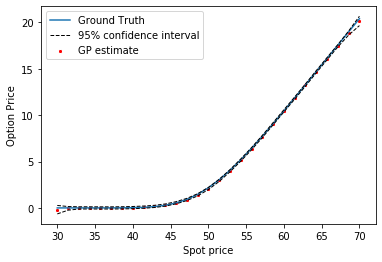

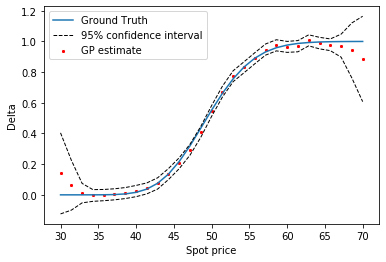

In [7]:
#Plot the estimates for the option price, delta and theta
GPR.plot_price(y_test,bounds=True)
GPR.plot_delta(delta_test,bounds=True,fig_name = 'Figures/matern52_halton_mc.pdf')
GPR.isTimeToMaturity = True
#GPR.plot_theta(theta_test)#,fig_name = 'Figures/illustration_theta_mc.pdf')
#aGPR.plot_delta(delta_test)

In [8]:
aGPR = GPR_analytical(my_kernel,X,y,mean_f,sn2,X_test)
aGPR.V_g()

<tf.Tensor: shape=(29,), dtype=float64, numpy=
array([0.01638105, 0.00618118, 0.00094348, 0.0003409 , 0.00032768,
       0.00029214, 0.0003143 , 0.00032931, 0.00031774, 0.0003048 ,
       0.00029973, 0.00029931, 0.00030591, 0.00030944, 0.00030639,
       0.00030535, 0.00031564, 0.00030479, 0.0003152 , 0.00029157,
       0.00031871, 0.00029882, 0.00030848, 0.00031033, 0.00035075,
       0.00037782, 0.00113846, 0.00705994, 0.01762135])>

In [7]:
GPR.V_g()

<tf.Tensor: shape=(29,), dtype=float64, numpy=
array([0.01638189, 0.00618183, 0.00094372, 0.00034096, 0.00032774,
       0.0002922 , 0.00031436, 0.00032936, 0.0003178 , 0.00030486,
       0.00029979, 0.00029937, 0.00030596, 0.0003095 , 0.00030645,
       0.00030541, 0.00031569, 0.00030485, 0.00031526, 0.00029163,
       0.00031877, 0.00029887, 0.00030854, 0.00031039, 0.00035082,
       0.00037788, 0.00113871, 0.00706054, 0.01762209])>

In [19]:
# Metrics for Delta

my_GPR = GPR

# 1. RMSE error
print('### METRIC 1: Root Mean Squared Error ###')
from sklearn.metrics import mean_squared_error as mse
rmse = np.sqrt(mse(delta_test,my_GPR.delta()))
print('RMSE = ', rmse)

# 2. Profit and Loss
# print('\n### METRIC 2: Profit and Loss ###')
# from my_metrics import PnL
# paths = bs_model.generate_paths(200,mu=0.06,N=20,S0=50,normal=True,var=2)
# pnl = PnL(paths,bs_model,my_kernel,X,y,mean_f,l=2)
# print('Pnl = ', pnl)

# 3. Median Absolute Deviation
print('\n### METRIC 3: Median Absolute Deviation ###')
mad = np.median(np.abs(delta_test-my_GPR.delta()))
print('MAD = ', mad)

# 4. Coverage
print('\n### METRIC 4: Coverage ###')
up = delta_test>my_GPR.bounds_delta(0.95)[0] 
low = delta_test<my_GPR.bounds_delta(0.95)[1]
in_bounds = up.numpy()*low.numpy()
coverage = 1/len(X_test) * np.sum(in_bounds)
print('Cvr = ', coverage)

# 5. Negative Log Probability Density
print('\n### METRIC 5: Negative Log Probability Density ###')
nlpd = (delta_test-my_GPR.delta())**2/my_GPR.V_g()+tf.math.log(my_GPR.V_g())
print('NLPD = ', np.mean(nlpd))

### METRIC 1: Root Mean Squared Error ###
RMSE =  0.07977313447865512

### METRIC 3: Median Absolute Deviation ###
MAD =  0.013804223707270857

### METRIC 4: Coverage ###
Cvr =  1.0

### METRIC 5: Negative Log Probability Density ###
NLPD =  -5.223518137786679
